In [ ]:
import os
import pickle
from cedne import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import datetime
from statsmodels.stats.multitest import multipletests
import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [ ]:
pickleDir = 'pickles/2025-12-15/'

genotypes = ['N2', 'inx-7-mutant', 'inx-7-rescue']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
conditions = ['naive', 'trained']

wormDict = { genotype:{
                    promoter:{
                        stimulus: {
                            condition: {} for condition in conditions
                        } for stimulus in stimuli
                    } for promoter in promoters
                } for genotype in genotypes 
            }

for pf in os.listdir(pickleDir):
    print(pf)
    if not pf.startswith('.'):
        genotype, promoter, stimulus, condition, *name = pf.split('_')
        if not all ([genotype in genotypes, promoter in promoters, stimulus in stimuli, condition in conditions]):
            print(genotype in genotypes, promoter in promoters, stimulus in stimuli, condition in conditions, name)
        else:
            with open(pickleDir + pf, 'rb') as po:
                w = pickle.load(po)
                wormDict[genotype][promoter][stimulus][condition].update({w.name:w})

N2_ncs-1_OP-PA-OP_naive_ncs-1p 20230404 naive-worm3
N2_acr-5_Buffer-PA-Buffer_trained_acr-5p image 20220315trained-worm2
N2_flp-3p+flp-7p+nmr-1p+sro-1p_OP-PA-OP_trained_20240402-ZC4061-trained-OP-PA-30s-worm004
N2_inx-4+mbr-1_OP-PA-OP_naive_inx-4+mbr-1p 20221012 naive-worm2
N2_flp-3p+flp-7p+nmr-1p+sro-1p_Buffer-PA-Buffer_naive_20240116-PA-Buffer-naive-worm3
N2_odr-2(2b)+odr-2(18)p_OP-PA-OP_naive_20250423-ZC4164-Naive-OP-PA-worm004
N2_ncs-1_Buffer-PA-Buffer_trained_ncs-1p 20221107 trained-worm3
N2_ncs-1_OP-gacA-OP_naive_ncs-1p_20240529-naive-OP_gacA_OP-worm004
N2_glr-1_Buffer-PA-Buffer_trained_20211004-ZC3292-PA-Buffer-30s-trained-worm1
N2_flp-3p+flp-7p+nmr-1p+sro-1p_OP-PA-OP_trained_20240402-ZC4061-trained-OP-PA-30s-worm003
N2_ncs-1_OP-PA-OP_naive_ncs-1p 20230404 naive-worm4
N2_inx-4+mbr-1_OP-PA-OP_naive_inx-4+mbr-1p image 20221006naive-worm2
N2_odr-2(2b)+odr-2(18)p_Buffer-PA-Buffer_trained_20250409-ZC4164-trained-PA-Buffer-30s-worm002
N2_ncs-1_Buffer-PA-Buffer_trained_ncs-1p 20221107 

## LR differences

In [42]:
def left_side_neuron(n):
    if n.endswith('L') and not n in ['ADL', 'OLL']:
        return True
def right_side_neuron(n):
    if n.endswith('R') and not n in ['RIR']: 
        return True

In [4]:
from matplotlib.patches import Polygon
from scipy.stats import gaussian_kde
def half_violinplot(ax, data, position, side='right', width=0.8, bw_method=None,
                    color='C0', alpha=0.6, edgecolor='black', num_threshold=3):
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    if len(data) < num_threshold:
        return 0,0  # nothing drawn, return 0 height
    kde = gaussian_kde(data, bw_method=bw_method)
    ymin, ymax = data.min(), data.max()
    y = np.linspace(ymin, ymax, 200)
    density = kde(y)
    density = density / density.max() * (width / 2)

    x = position + density if side == 'right' else position - density
    verts = np.column_stack([x, y])
    verts = np.concatenate([
        [[position, y[0]]],
        verts,
        [[position, y[-1]]]
    ])
    poly = Polygon(verts, facecolor=color, edgecolor=edgecolor, alpha=alpha)
    ax.add_patch(poly)

    return y.min(), y.max()  # return actual y limit

def plot_valence_split_violin(active_neurons, genotype, stimulus, periods, measure='', save=False, pval_thres=0.05):

    ods = stimulus.split('-')
    if ods[0] == 'OP':
        ods[0] = 'OP50'
    elif ods[0] == 'PA':
        ods[0] = 'PA14'
    elif ods[0] == 'gacA':
        ods[1] = 'PA14-$\\it{gacA(-)}$'

    if ods[1] == 'OP':
        ods[1] = 'OP50'
    elif ods[1] == 'PA':
        ods[1] = 'PA14'
    elif ods[1] == 'gacA':
        ods[1] = 'PA14-$\\it{gacA(-)}$'
        
    if ods[2] == 'OP':
        ods[2] = 'OP50'
    
    transition1 = f'{ods[1]}'
    transition2 = f'{ods[2]}'

    data = active_neurons[genotype][stimulus]
    conditions = ['naive', 'trained']
    windows = [transition1, transition2]
    records = []
    neuron_order = 'sensory', 'interneuron', 'motorneuron'
    # Create a mapping for neuron type order
    type_order_map = {neuron_type: i for i, neuron_type in enumerate(neuron_order)}

    # Sort neurons first by neuron type (according to neuron_order) and then alphabetically
    all_neurons = sorted(
        {n for c in conditions for n in data.get(c, {})},
        key=lambda n: (type_order_map.get(nn.neurons[n].type, float('inf')), n)
    )

    # Determine indices where neuron type changes
    separation_indices = [i for i, (prev, curr) in enumerate(zip(all_neurons[:-1], all_neurons[1:]), 1) if nn.neurons[prev].type != nn.neurons[curr].type]

    # all_neurons = sorted({n for c in conditions for n in data.get(c, {})})
    for neuron in all_neurons:
        for cond in conditions:
            if neuron not in data[cond]: continue
            for i, win_label in enumerate(windows):
                val1, val2, pval, sgn = data[cond][neuron][i]
                for v1, v2 in zip(val1, val2):
                    records.append({
                        'neuron': neuron,
                        'neuron-type': nn.neurons[neuron].type,
                        'condition': cond,
                        'window': win_label,
                        'val1': v1,
                        'val2': v2,
                        'pval': pval,
                        'positive_change': sgn
                    })

    df = pd.DataFrame.from_records(records)
    df['neuron'] = pd.Categorical(df['neuron'], categories=all_neurons, ordered=True)

    df['adjusted_pval'] = np.nan
    df['significant'] = False

    # Apply BH correction per condition × window
    for (cond, win), group in df.groupby(['condition', 'window']):
        pvals = group['pval'].unique()  # or just group['pval'] if repeats are okay
        if len(pvals) > 1:
            reject, pvals_corrected, _, _ = multipletests(pvals, alpha=pval_thres, method='fdr_bh')
            pval_map = dict(zip(pvals, zip(reject, pvals_corrected)))
            df.loc[group.index, 'adjusted_pval'] = group['pval'].map(lambda p: pval_map.get(p, (False, np.nan))[1])
            df.loc[group.index, 'significant'] = group['pval'].map(lambda p: pval_map.get(p, (False, np.nan))[0])

    # Create 4-row layout: (naive, trained) × (first, second)
    bigplot_size = (double_column, max_height/2)
    smallplot_size = (single_column, max_height/2)
    if len(all_neurons)<=20:
        figsize = mm_to_inches(smallplot_size) #max(10, len(all_neurons)*0.4), 10)
    else:
        figsize = mm_to_inches(bigplot_size) #max(10, len(all_neurons)*0.4), 10)

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True, sharey=True, layout='constrained')

    row_map = {
        ('naive', transition1): 0,
        ('naive', transition2): 1,
        ('trained', transition1): 2,
        ('trained', transition2): 3
    }
    color_map = color_conds#{
        # 'naive': color_conds['naive'],
        # 'trained': color_conds['trained']
    # }

    sig_neurs = {cond: {win: set() for win in windows} for cond in conditions}
    sign_neurs = {cond: {win: {} for win in windows} for cond in conditions}
    for (cond, window), row in row_map.items():
        ax = axes[row]
        subdf = df[(df['condition'] == cond) & (df['window'] == window)]
        ymax = 0
        ymin = 0

        for x, neuron in enumerate(all_neurons):
            d = subdf[subdf['neuron'] == neuron]
            v1 = d['val1'].dropna()
            v2 = d['val2'].dropna()

            ymn1, ymx1 = half_violinplot(ax, v1, position=x, side='left', color=color_map[cond], edgecolor=color_map[cond])
            ymn2, ymx2 = half_violinplot(ax, v2, position=x, side='right', color=color_map[cond], edgecolor=color_map[cond])
            ymax = max(ymax, ymx1, ymx2)
            ymin = min(ymin, ymn1, ymn2)

            if d['significant'].any():
                all_vals = pd.concat([v1, v2])
                if len(all_vals):
                    val = all_vals.max()
                    ymax = max(ymax, val)
                    ymin = min(ymin, val)
                    ax.text(x, val + 0.05*abs(val), '*', ha='center', va='bottom', fontsize=font_size_mid)
                    sig_neurs[cond][window].add(neuron)
                    
            vals = np.asarray(pd.Series(d['positive_change']).explode().astype(bool))
            if neuron == 'AWB':
                print(neuron, cond, window, vals)
            is_pos = bool(np.all(vals))
            sign_neurs[cond][window][neuron] = 'positive' if is_pos else 'negative'

        ax.set_ylabel(f"{window}", fontsize=font_size_mid)
        ax.set_xlim((-1,len(all_neurons)+1))
        ax.set_xticks(range(len(all_neurons)))
        ax.set_xticklabels(all_neurons, rotation=45, fontsize=font_size_mid)

        # Pad y-axis if needed
        if ymax > 0:
            ax.set_ylim(top=ymax * 1.1)
        if ymin < 0:
            ax.set_ylim(bottom=ymin * 1.1)
        
        for idx in separation_indices:
            ax.axvline(idx - 0.5, linestyle='--', color='gray', alpha=0.5)

    
    axes[-1].set_xlabel("Neuron", fontsize=font_size_mid)
    utils.simpleaxis(axes)
    # plt.tight_layout()
    stimulus = stimulus.replace('OP', 'OP50').replace('PA', 'PA14').replace('gacA', 'PA14-$\\it{gacA(-)}$')
    fig.suptitle(f'{stimulus} {measure} (left= {int(periods[0])/5}s before, right= {int(periods[1])/5}s after transition)', fontsize=font_size_mid)
    if not save:
        plt.show()
        plt.close()
    else:
        plt.savefig(save, transparent=True, dpi=300)
        plt.show()
        plt.close()
    return sig_neurs, sign_neurs

N2 ncs-1 OP-PA-OP naive : 19 worms
N2 inx-4 OP-PA-OP naive : 28 worms
N2 glr-1 OP-PA-OP naive : 27 worms
N2 acr-5 OP-PA-OP naive : 27 worms
N2 inx-4+mbr-1 OP-PA-OP naive : 26 worms
N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP naive : 22 worms
N2 odr-2(2b)+odr-2(18)p OP-PA-OP naive : 22 worms
Left ASGL: (39, 450)
Left ASIL: (18, 450)
Left AFDL: (21, 450)
Left AWBL: (16, 450)
Left AWCL: (20, 450)
Left ASEL: (16, 450)
Left ADFL: (13, 450)
Left ASHL: (10, 450)
Left BAGL: (32, 450)
Left OLLL: (51, 450)
Left AWAL: (12, 450)
Left AIYL: (4, 450)
Left SAAVL: (37, 450)
Left AVKL: (13, 450)
Left RMGL: (4, 450)
Left SAADL: (25, 450)
Left RIGL: (52, 450)
Left AVFL: (19, 450)
Left AIML: (17, 450)
Left AINL: (20, 450)
Left RICL: (13, 450)
Left RIML: (38, 450)
Left FLPL: (13, 450)
Left IL1L: (49, 450)
Left ADAL: (11, 450)
Left RIPL: (4, 450)
Left AVJL: (6, 450)
Left IL1DL: (45, 450)
Left IL1VL: (58, 450)
Left AVEL: (31, 450)
Left AVAL: (29, 450)
Left SMDVL: (21, 450)
Left SIBVL: (23, 450)
Left AVDL: (17, 4

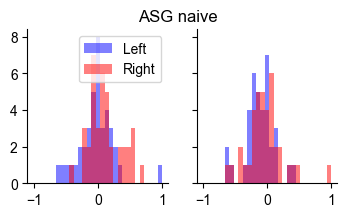

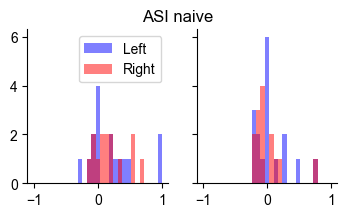

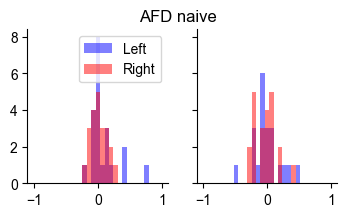

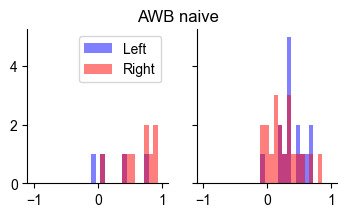

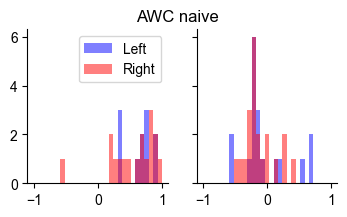

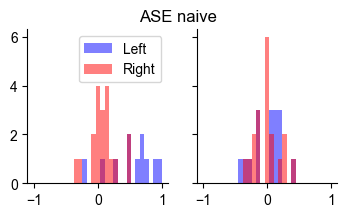

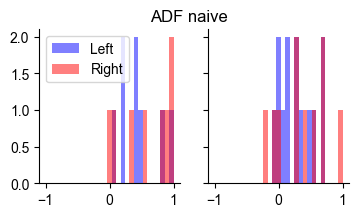

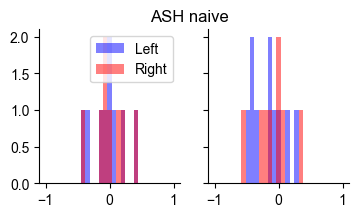

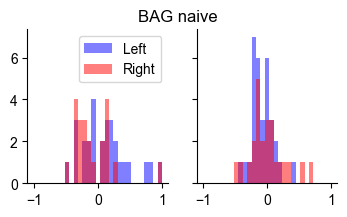

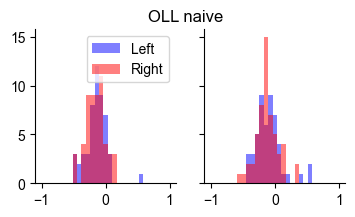

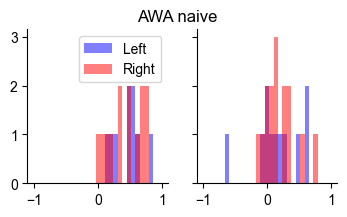

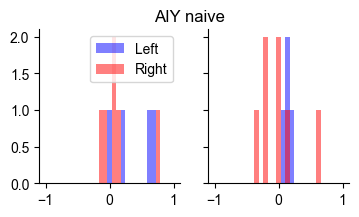

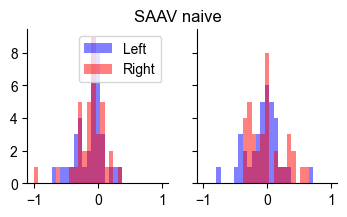

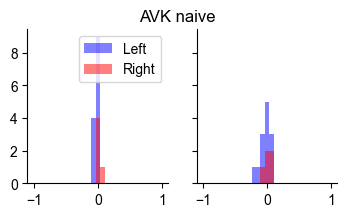

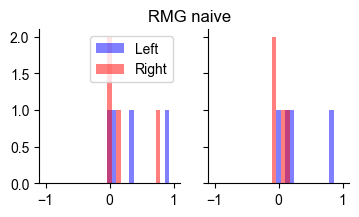

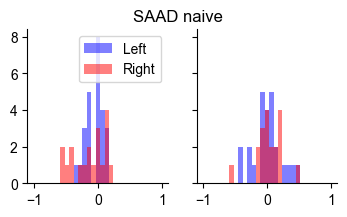

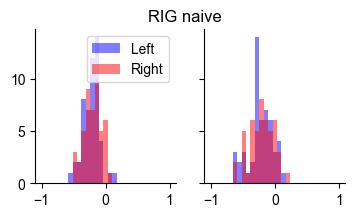

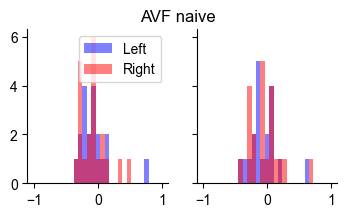

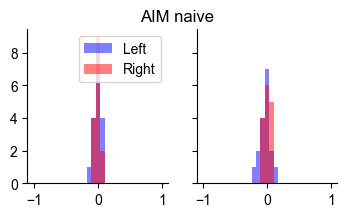

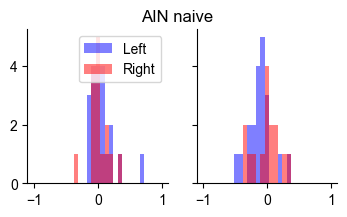

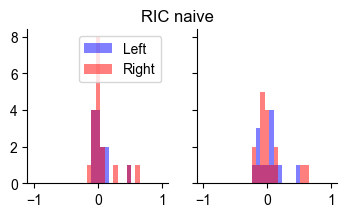

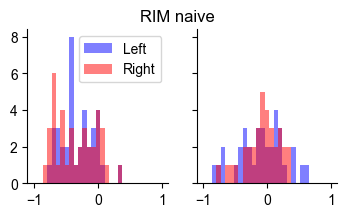

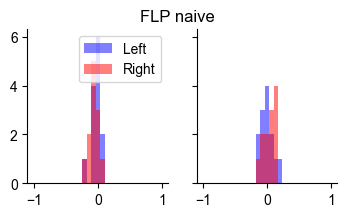

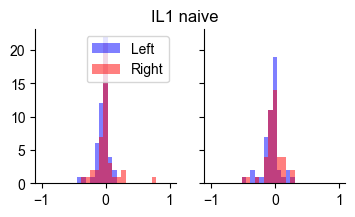

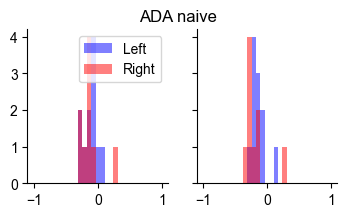

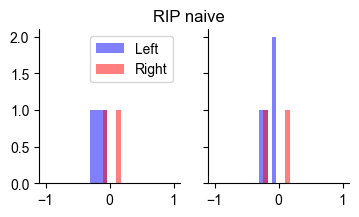

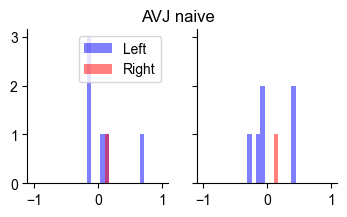

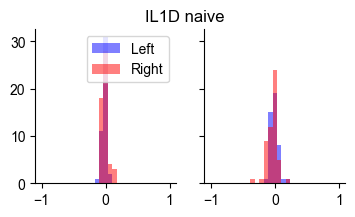

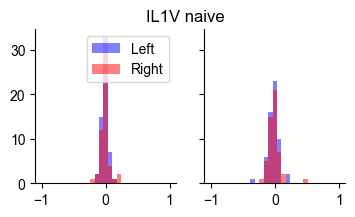

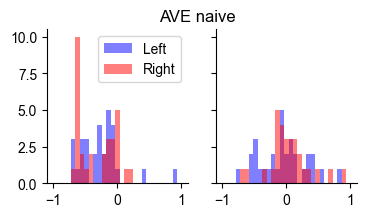

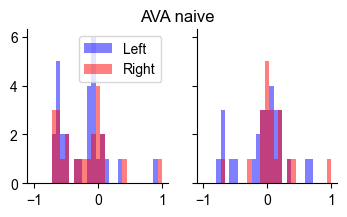

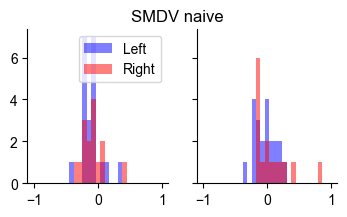

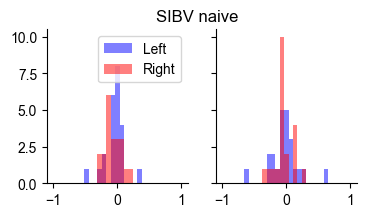

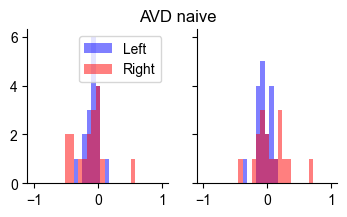

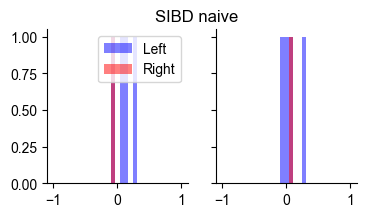

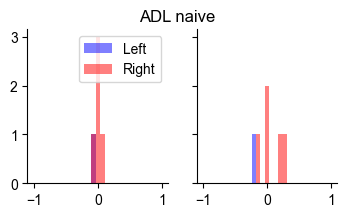

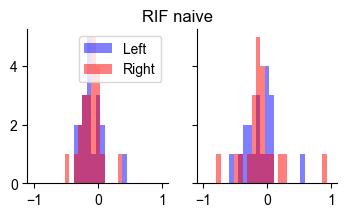

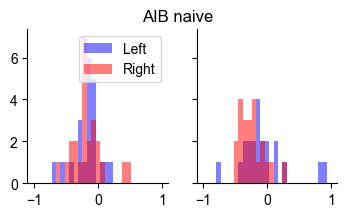

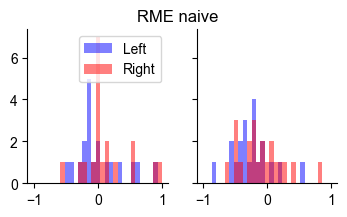

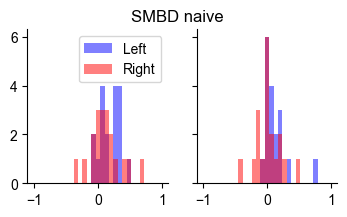

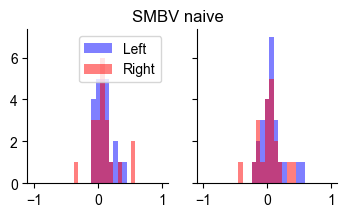

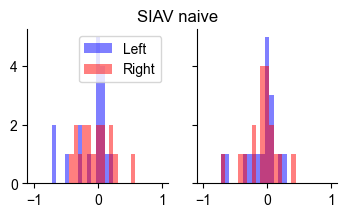

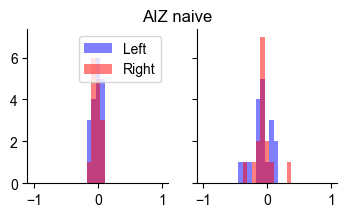

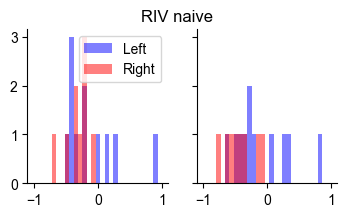

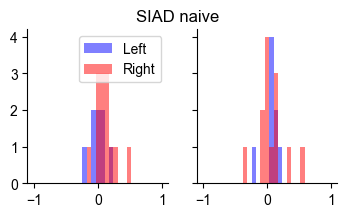

N2 ncs-1 OP-PA-OP trained : 20 worms
N2 inx-4 OP-PA-OP trained : 28 worms
N2 glr-1 OP-PA-OP trained : 23 worms
N2 acr-5 OP-PA-OP trained : 30 worms
N2 inx-4+mbr-1 OP-PA-OP trained : 28 worms
N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP trained : 21 worms
N2 odr-2(2b)+odr-2(18)p OP-PA-OP trained : 21 worms
Left ASGL: (39, 450)
Left ASIL: (12, 450)
Left AFDL: (20, 450)
Left AWAL: (15, 450)
Left AWBL: (15, 450)
Left AWCL: (20, 450)
Left ASEL: (19, 450)
Left BAGL: (24, 450)
Left SAAVL: (27, 450)
Left ASKL: (2, 450)
Left ADFL: (12, 450)
Left ASHL: (11, 450)
Left OLLL: (48, 450)
Left AVKL: (12, 450)
Left SAADL: (17, 450)
Left AIYL: (5, 450)
Left RMGL: (7, 450)
Left ADLL: (9, 450)
Left RIGL: (60, 450)
Left AVFL: (22, 450)
Left AIML: (20, 450)
Left AINL: (16, 450)
Left RIML: (42, 450)
Left RICL: (21, 450)
Left RIPL: (5, 450)
Left FLPL: (14, 450)
Left ADAL: (12, 450)
Left AVJL: (3, 450)
Left IL1L: (45, 450)
Left IL1DL: (43, 450)
Left IL1VL: (51, 450)
Left AVDL: (15, 450)
Left AVEL: (24, 450)
Left AV

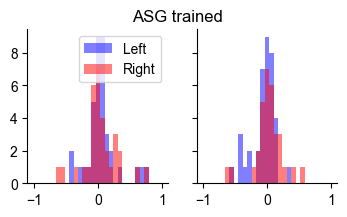

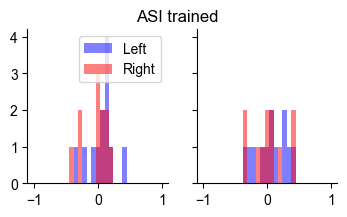

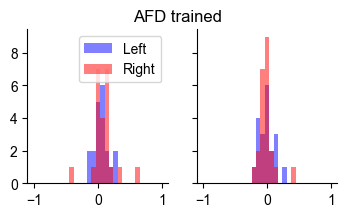

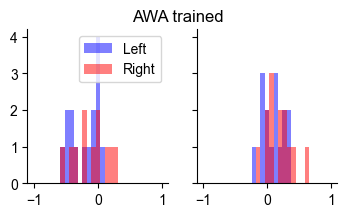

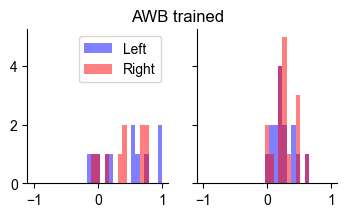

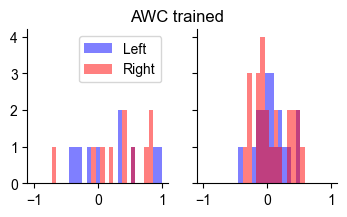

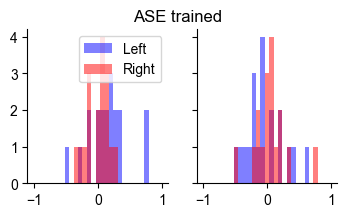

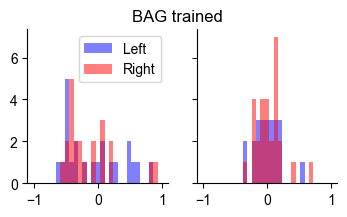

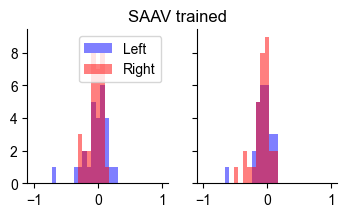

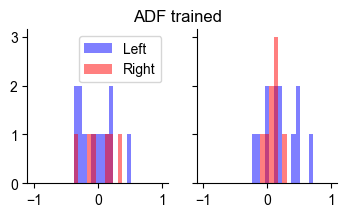

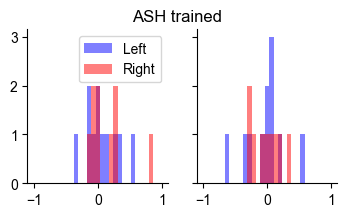

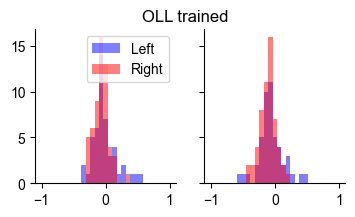

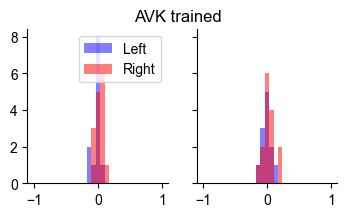

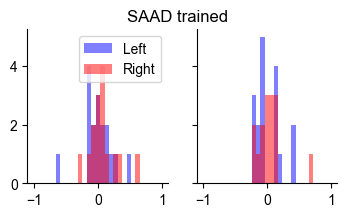

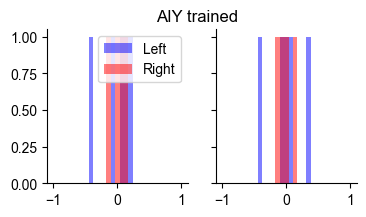

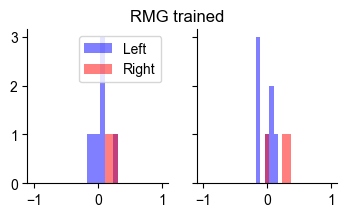

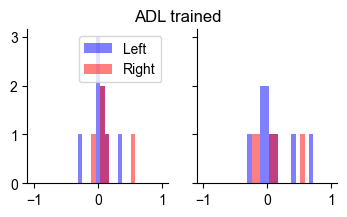

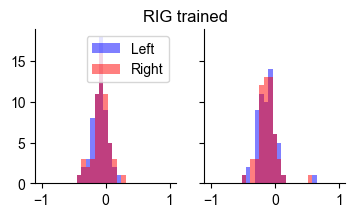

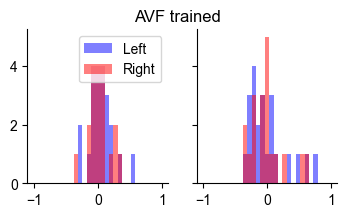

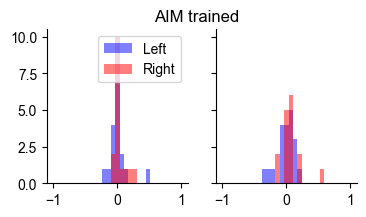

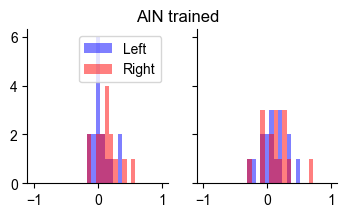

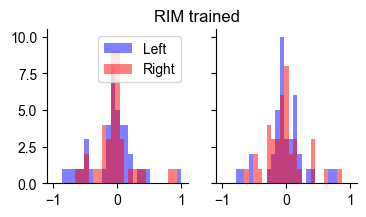

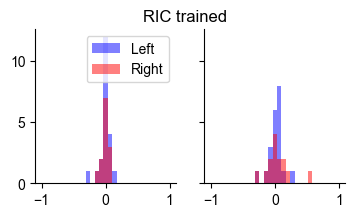

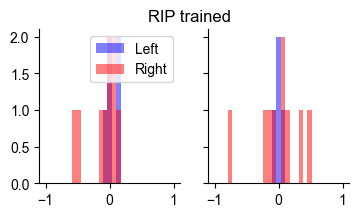

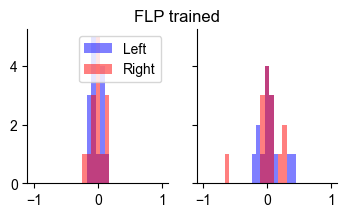

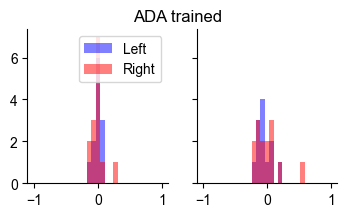

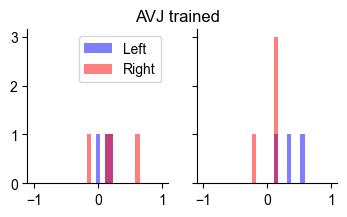

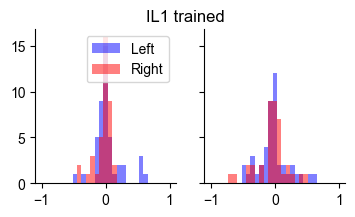

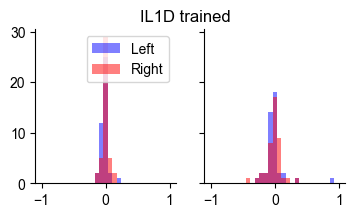

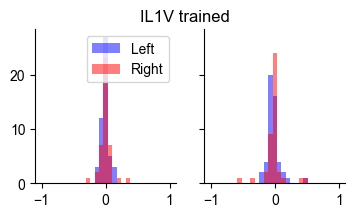

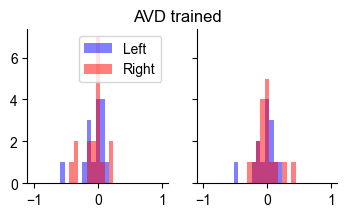

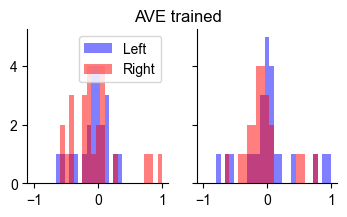

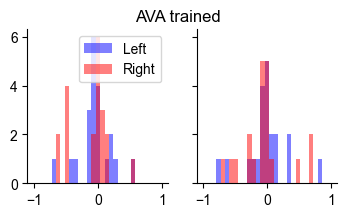

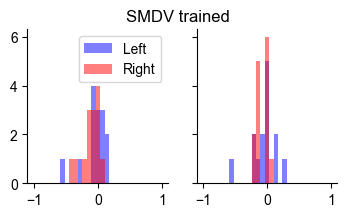

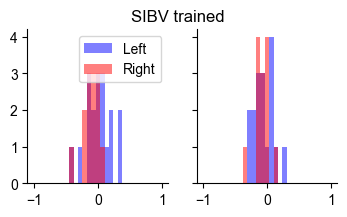

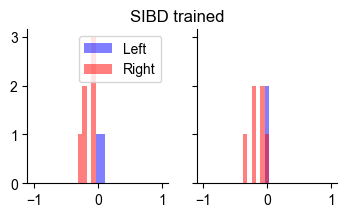

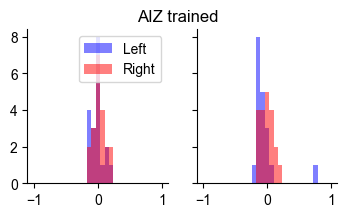

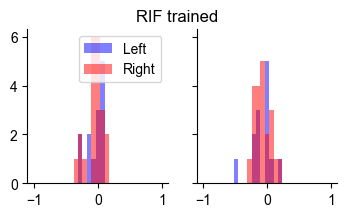

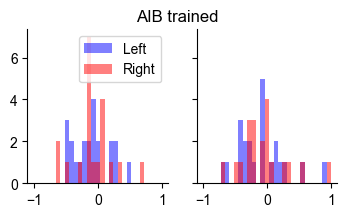

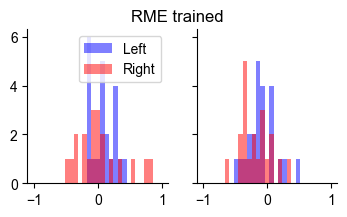

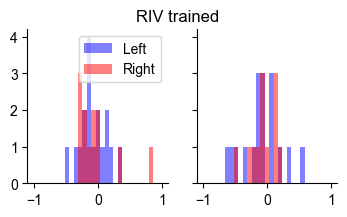

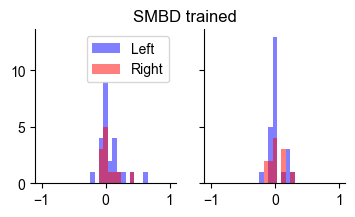

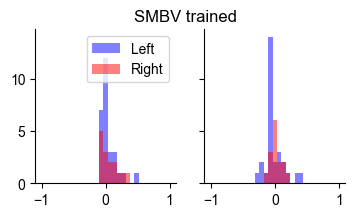

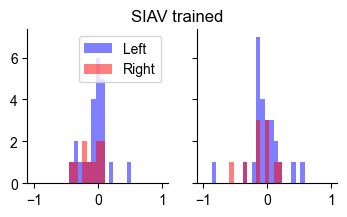

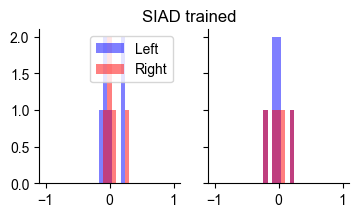

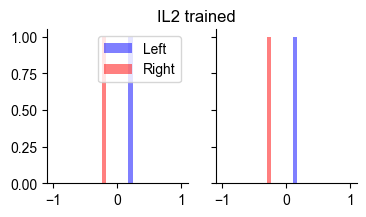

In [49]:
genotype_filter = ['N2']
stimulus_filter = ['OP-PA-OP']
# stimulus_filter = ['Buffer-PA-Buffer']
naive_sig = {}
trained_sig = {}
for cond_filter in ['naive', 'trained']:
    left_data = {}
    right_data = {}
    for genotype in wormDict:
        if genotype in genotype_filter:
            for promoter in wormDict[genotype]:
                for stimulus in wormDict[genotype][promoter]:
                    if stimulus in stimulus_filter:
                        for condition in wormDict[genotype][promoter][stimulus]:
                            if condition in cond_filter:
                                worms = wormDict[genotype][promoter][stimulus][condition]
                                if len(worms):
                                    print(f'{genotype} {promoter} {stimulus} {condition} : {len(worms)} worms')
                                    for wname in worms:
                                        nn = wormDict[genotype][promoter][stimulus][condition][wname].networks[condition]
                                        for n in nn.neurons:
                                            if left_side_neuron(n):
                                                for k in nn.neurons[n].trial:
                                                    left_data.setdefault(n, [])
                                                    left_data[n].append(nn.neurons[n].trial[k]._data)
                                            elif right_side_neuron(n):
                                                for k in nn.neurons[n].trial:
                                                    right_data.setdefault(n, [])
                                                    right_data[n].append(nn.neurons[n].trial[k]._data)

    for n in left_data:
        left_data[n] = np.array(left_data[n])
        print(f'Left {n}: {left_data[n].shape}')
    for n in right_data:
        right_data[n] = np.array(right_data[n])
        print(f'Right {n}: {right_data[n].shape}')


    left_data_median = {}
    right_data_median = {}
    period1 = (150,300)
    period2 = (300,450)
    for n in left_data:
        class_n = n[:-1]
        if class_n+ 'R' in right_data:
            left_data_median[class_n] = {}
            right_data_median[class_n] = {}
            left_data_median[class_n]['period_1'] = np.median(left_data[class_n+'L'][:,period1[0]:period1[1]], axis=1)
            right_data_median[class_n]['period_1'] = np.median(right_data[class_n+'R'][:,period1[0]:period1[1]], axis=1)
            left_data_median[class_n]['period_2'] = np.median(left_data[class_n+'L'][:,period2[0]:period2[1]], axis=1)
            right_data_median[class_n]['period_2'] = np.median(right_data[class_n+'R'][:,period2[0]:period2[1]], axis=1)

            test = ss.ttest_ind(left_data_median[class_n]['period_1'], right_data_median[class_n]['period_1'], axis=0, equal_var=False)

            bins = np.linspace(-1, 1, 30)
            f, ax = plt.subplots(figsize=(4,2), ncols=2, sharex=True, sharey=True)
            ax[0].hist(left_data_median[class_n]['period_1'], bins=bins, color='blue', alpha=0.5, label='Left')
            ax[0].hist(right_data_median[class_n]['period_1'], bins=bins, color='red', alpha=0.5, label='Right')
            ax[0].legend()
            ax[0].set_title(f'{n[:-1]} p={test.pvalue:.2f}')
            test2 = ss.ttest_ind(left_data_median[class_n]['period_2'], right_data_median[class_n]['period_2'], axis=0, equal_var=False)
            ax[1].hist(left_data_median[class_n]['period_2'], bins=bins, color='blue', alpha=0.5, label='Left')
            ax[1].hist(right_data_median[class_n]['period_2'], bins=bins, color='red', alpha=0.5, label='Right')
            utils.simpleaxis(ax)
            f.suptitle(f'{n[:-1]} {cond_filter}')
            
            plt.show()
            if cond_filter == 'naive':
                if not np.isnan(test.pvalue) or not np.isnan(test2.pvalue):
                    naive_sig[class_n] = (test.pvalue, test2.pvalue)
            else:
                if not np.isnan(test.pvalue) or not np.isnan(test2.pvalue):
                    trained_sig[class_n] = (test.pvalue, test2.pvalue)

In [50]:
pthres = 0.05

# Collect all p-values with keys
pvalue_records = []
for n in naive_sig:
    pvalue_records.append({'cond': 'naive', 'neuron': n, 'period': 1, 'pval': naive_sig[n][0]})
    pvalue_records.append({'cond': 'naive', 'neuron': n, 'period': 2, 'pval': naive_sig[n][1]})
for n in trained_sig:
    pvalue_records.append({'cond': 'trained', 'neuron': n, 'period': 1, 'pval': trained_sig[n][0]})
    pvalue_records.append({'cond': 'trained', 'neuron': n, 'period': 2, 'pval': trained_sig[n][1]})

# Filter out NaN p-values before correction
valid_records = [r for r in pvalue_records if not np.isnan(r['pval'])]
pvalues = [r['pval'] for r in valid_records]
reject, pvals_corrected, _, _ = multipletests(pvalues, alpha=pthres, method='fdr_bh')

# Build lookup
pval_lookup = {}
for i, r in enumerate(valid_records):
    pval_lookup[(r['cond'], r['neuron'], r['period'])] = pvals_corrected[i]

# Report significant results
for cond in ['naive', 'trained']:
    sig_dict = naive_sig if cond == 'naive' else trained_sig
    for n in sig_dict:
        p1 = pval_lookup.get((cond, n, 1), np.nan)
        p2 = pval_lookup.get((cond, n, 2), np.nan)
        if p1 < pthres:
            print(f'{cond.capitalize()} {n} period 1 significant: p={p1:.3f}')
        if p2 < pthres:
            print(f'{cond.capitalize()} {n} period 2 significant: p={p2:.3f}')

Naive ASE period 1 significant: p=0.035


In [53]:
# Same worm

genotype_filter = ['N2']
# stimulus_filter = ['OP-PA-OP']
stimulus_filter = ['Buffer-PA-Buffer']
median_diff_neurs = {}
trained_sig_same_worm = {}

for cond_filter in ['naive', 'trained']:
    median_diff_neurs[cond_filter] = {}
    diff_neurons = {} 
    for genotype in wormDict:
        if genotype in genotype_filter:
            for promoter in wormDict[genotype]:
                for stimulus in wormDict[genotype][promoter]:
                    if stimulus in stimulus_filter:
                        for condition in wormDict[genotype][promoter][stimulus]:
                            if condition in cond_filter:
                                worms = wormDict[genotype][promoter][stimulus][condition]
                                if len(worms):
                                    print(f'{genotype} {promoter} {stimulus} {condition} : {len(worms)} worms')
                                    for wname in worms:
                                        nn = wormDict[genotype][promoter][stimulus][condition][wname].networks[condition]
                                        left_data = {}
                                        right_data = {}
                                        for n in nn.neurons:    
                                            if left_side_neuron(n):
                                                for k in nn.neurons[n].trial:
                                                    left_data.setdefault(n, [])
                                                    left_data[n].append(nn.neurons[n].trial[k]._data)
                                            elif right_side_neuron(n):
                                                for k in nn.neurons[n].trial:
                                                    right_data.setdefault(n, [])
                                                    right_data[n].append(nn.neurons[n].trial[k]._data)
                                        
                                        #Left - right
                                        for n in left_data:
                                            class_n = n[:-1]
                                            if class_n + 'R' in right_data:
                                                if len(left_data[n]) > 0 and len(right_data[class_n+'R']) > 0:
                                                    diff_neurons.setdefault(class_n, [])
                                                    for k in range(len(left_data[n])):
                                                        for l in range(len(right_data[class_n+'R'])):
                                                            diff_neurons[class_n].append(left_data[n][k] - right_data[class_n+'R'][l])

    # Now store per-condition data
    period1 = (150, 300)
    period2 = (300, 450)
    for n in diff_neurons:
        median_diff_neurs[cond_filter][n] = {}
        median_diff_neurs[cond_filter][n]['period_1'] = np.median(np.array(diff_neurons[n])[:, period1[0]:period1[1]], axis=1)
        median_diff_neurs[cond_filter][n]['period_2'] = np.median(np.array(diff_neurons[n])[:, period2[0]:period2[1]], axis=1)

N2 ncs-1 Buffer-PA-Buffer naive : 23 worms
N2 inx-4 Buffer-PA-Buffer naive : 21 worms
N2 glr-1 Buffer-PA-Buffer naive : 20 worms
N2 acr-5 Buffer-PA-Buffer naive : 29 worms
N2 inx-4+mbr-1 Buffer-PA-Buffer naive : 21 worms
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer naive : 23 worms
N2 odr-2(2b)+odr-2(18)p Buffer-PA-Buffer naive : 25 worms
N2 ncs-1 Buffer-PA-Buffer trained : 24 worms
N2 inx-4 Buffer-PA-Buffer trained : 23 worms
N2 glr-1 Buffer-PA-Buffer trained : 27 worms
N2 acr-5 Buffer-PA-Buffer trained : 31 worms
N2 inx-4+mbr-1 Buffer-PA-Buffer trained : 23 worms
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer trained : 18 worms
N2 odr-2(2b)+odr-2(18)p Buffer-PA-Buffer trained : 25 worms


In [54]:
# Collect p-values with keys
pvalue_records = []
for cond_filter in ['naive', 'trained']:
    for n in median_diff_neurs[cond_filter]:
        p1 = median_diff_neurs[cond_filter][n]['period_1']
        p2 = median_diff_neurs[cond_filter][n]['period_2']
        if len(p1) <= 1 or len(p2) <= 1:
            continue
        test1 = ss.ttest_1samp(p1, 0, axis=0)
        test2 = ss.ttest_1samp(p2, 0, axis=0)
        pvalue_records.append({'cond': cond_filter, 'neuron': n, 'period': 1, 'pval': test1.pvalue})
        pvalue_records.append({'cond': cond_filter, 'neuron': n, 'period': 2, 'pval': test2.pvalue})

# Correct for multiple comparisons
pvalues = [r['pval'] for r in pvalue_records]
reject, pvals_corrected, _, _ = multipletests(pvalues, alpha=pthres, method='fdr_bh')

# Build lookup dict: (cond, neuron, period) -> corrected p-value
pval_lookup = {}
for i, r in enumerate(pvalue_records):
    pval_lookup[(r['cond'], r['neuron'], r['period'])] = pvals_corrected[i]

# Plot using the lookup
for cond_filter in ['naive', 'trained']:
    for n in median_diff_neurs[cond_filter]:
        p1 = median_diff_neurs[cond_filter][n]['period_1']
        p2 = median_diff_neurs[cond_filter][n]['period_2']
        if len(p1) <= 1 or len(p2) <= 1:
            continue
        
        pval1 = pval_lookup.get((cond_filter, n, 1), np.nan)
        pval2 = pval_lookup.get((cond_filter, n, 2), np.nan)
        
        if pval1 < pthres or pval2 < pthres:
            f, ax = plt.subplots(figsize=(4, 2), ncols=2, sharex=True, sharey=True)
            ax[0].hist(p1)
            ax[1].hist(p2)
            utils.simpleaxis(ax)
            f.suptitle(f'{n} ({cond_filter})')
            ax[0].set_title(f'p={pval1:.2f}')
            ax[1].set_title(f'p={pval2:.2f}')
            plt.show()